# Predicting RUL of EV Batteries

In this project, we apply Data Analysis and Machine Learning techniques to predict the **Remaining Useful Life (RUL)** of EV Batteries. We have used the Battery Degradation dataset available at the [Prognostic Centre of Excellence (PCoE)](http://ti.arc.nasa.gov/project/prognostic-data-repository).

In [1]:
# Importing required libraries for loading and storing the data from the matlab datafiles
from pymatreader import read_mat
import pandas as pd

# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simple_colors import *
sns.set()

### Data Description
4 Li-ion batteries were run through 3 operational profiles - charge, discharge and impedance at room temperature. 

1. Charging Profile - Each battery was charged a constant current (CC) of 1.5A till the battery voltage reached 4.2V. It was then charged in constant voltage (CV) mode until the charge current dropped to 20mA
2. Discharge Profile - Discharge was carried out at 2A CC until the battery voltage droped to 2.7V, 2.5V, 2.2V and 2.5V for each battery respectively
3. Impedance Profile - Used electrochemical impedance spectroscopy (EIS) sweeps from 0.1Hz to 5kHz

Each battery is subjected to 168 charge-discharge cycles which results in accelerated aging. The experiments were stopped once battery capacity diminished by 30% i.e. from 2 Ahr to 1.4 Ahr.

### Measurements
1. Charging fields
    * Battery terminal voltage (Volts) 
    * Battery output current (Amps)
    * Battery temperature (degree C)
    * Current measured at charger (Amps)
    * Voltage measured at charger (Volts)
    * Measurement time stamps (secs)
    
    
2. Discharging fields
    * Battery terminal voltage (Volts) 
    * Battery output current (Amps)
    * Battery temperature (degree C)
    * Current measured at load (Amps)
    * Voltage measured at load (Volts)
    * Measurement time stamps (secs)
    * **Battery capacity (Ahr) for discharge till 2.7V**

## Exploratory Data Analysis (EDA)

The data available is in a MATLAB structure and for ease of analysis, we use the [pymatreader](https://pypi.org/project/pymatreader/) module to load the data in Python. Data is separated into three dataframes for charge, discharge and impedance measurements respectively. 

Discharge data will be used for the purposes of RUL prediction while Impedance data will be used to explain the internal mechanisms resulting in battery degradation.

In [2]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    data = read_mat('B00' + num + '.mat')
    df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

# This function plots the data of specified type (voltage, current or temperature)
# for the cycle numbers specified by "cycle_list" argument
def dc_cycle_plots(cell_number, cycle_list, type, figsize = (10,5), only_scatter = False):
    _, discharge, _= split_data(cell_number)

    labels = {'voltage': 'Battery terminal voltage (V)',
              'current': 'Battery output current (A)',
              'temperature': 'Battery temperature (°C)'}
    type_ = type.capitalize() + '_measured'

    plt.figure(figsize = figsize)
    for cycle in cycle_list:
        time_data = discharge.iloc[cycle]['data']['Time']   # List of times obtained from the "discharge" dataframe
        type_data = discharge.iloc[cycle]['data'][type_]    # Data of the type specified, obtained from the "discharge" dataframe
        
        if not only_scatter: plt.plot(time_data, type_data, label = f"cycle {cycle}")
        plt.scatter(time_data, type_data, s = 5)
    plt.title(f"{type.capitalize()} Measured for cell number {cell_number}", fontsize = 14)
    plt.xlabel("Time (seconds)", fontsize = 14)
    plt.ylabel(labels[type], fontsize = 14)
    plt.legend()
    plt.show()

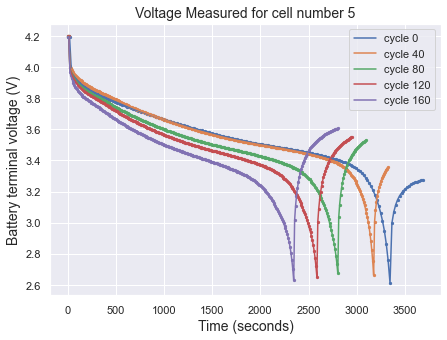

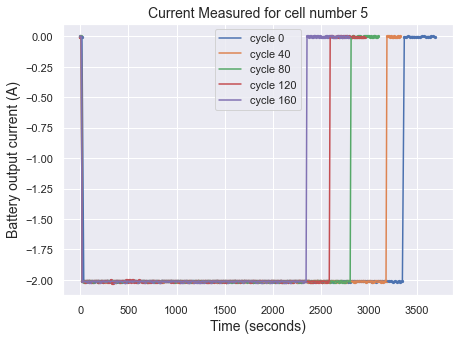

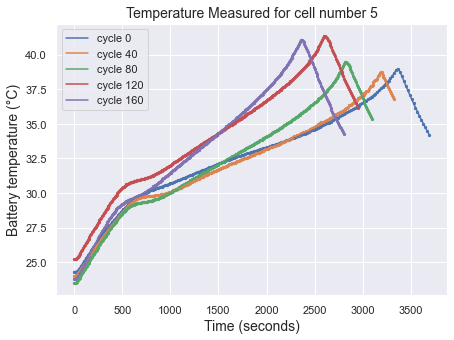

In [3]:
cycles = [0, 40, 80, 120, 160]
dc_cycle_plots(5, cycles, 'voltage', figsize = (7,5), only_scatter = False)
dc_cycle_plots(5, cycles, 'current', figsize = (7,5), only_scatter = False)
dc_cycle_plots(5, cycles, 'temperature', figsize = (7,5), only_scatter = False)

In [4]:
# This function performs the major preprocessing of the data, by picking out the data values 
# which will be used for training out of the complete available data
def preprocessing(cell_number, voltage_splits = 16):
    _, discharge, _ = split_data(cell_number)
    voltages = np.linspace(2.7, 4, voltage_splits)
    
    # features0 stores the Times at which terminal voltage is 2.7, ..., 4
    # features1 stores the Time to reach minimum terminal voltage
    # feature2 stores the Maximum temperature
    # feature3 stores the Time to reach maximum temperature
    
    feature0, feature1, feature2, feature3 = [], [], [], []
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']                       # Getting time data from the discharge dataframe
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']        # Getting voltage data
        temp_data = discharge.iloc[i]['data']['Temperature_measured']       # Getting temperature data

        times = []
        for j in range(voltage_splits):
            time_for_closest_voltage = time_data[np.argmin(np.abs(voltage_data - voltages[j]))]         # time at which the reading stored in "voltage_data" is closest 
            times.append(time_for_closest_voltage)                                                      # to one of the values in the "voltages" array
        
        feature0 = feature0 + [times]
        feature1.append(time_data[np.argmin(voltage_data)])
        feature2.append(np.max(temp_data))

        time_for_max_temp = time_data[np.argmax(temp_data)]                 # time at which temperature reaches its maximum value
        feature3.append(time_for_max_temp)

    # Using list comprehension: 
    # feature0 = [[discharge.iloc[i]['data']['Time'][np.argmin(np.abs(discharge.iloc[i]['data']['Voltage_measured'] - voltages[j]))] for j in range(len(voltages))] for i in range(len(discharge))]
    # feature1 = [discharge.iloc[i]['data']['Time'][np.argmin(discharge.iloc[i]['data']['Voltage_measured'])] for i in range(len(discharge))]
    # feature2 = [np.max(discharge.iloc[j]['data']['Temperature_measured']) for j in range(len(discharge))]
    # feature3 = [discharge.iloc[j]['data']['Time'][np.argmax(discharge.iloc[j]['data']['Temperature_measured'])] for j in range(len(discharge))]

    x = np.array(feature0)
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]

    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((x, feature1, feature2, feature3))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])
    
    return x, y

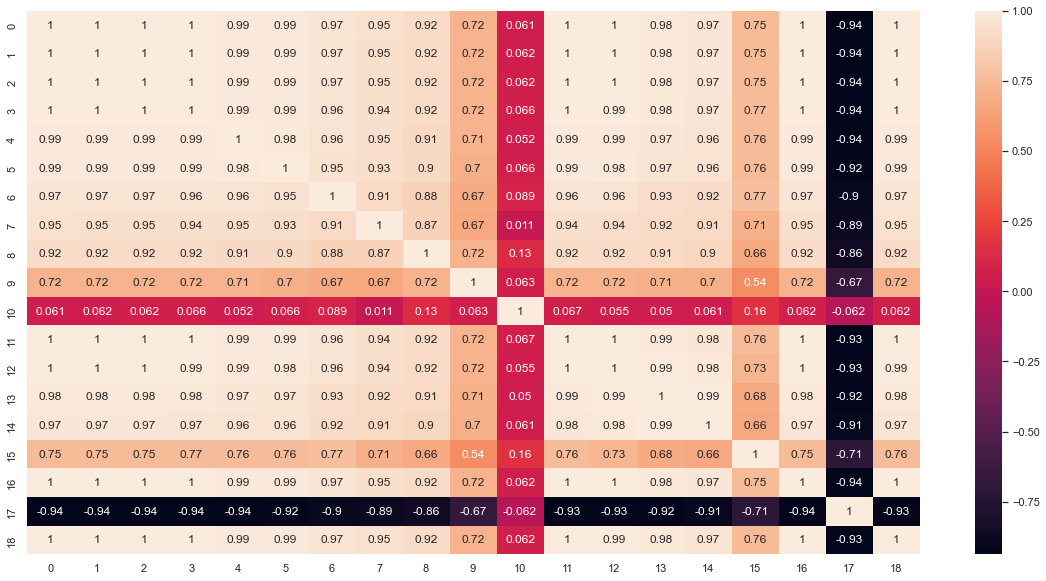

In [5]:
x, y = preprocessing(5, 16)

# Plot a correlation matrix to determine if there are any redundancies
corr = pd.DataFrame(x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, 
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 annot=True)

In [22]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, log_evaluation

from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [8]:
# This function prepares the x and y data for training by performing the test-train split, 
# and applying StandardScaler to normalize the values. The scaler is saved as a global
# variable so that it can be used to obtain the original data by performing inverse_transform
# (if needed)
def prep_for_training(x, y, scale_config = True):
    global scaler
    
    # Split the data in the ratio 80:20 for training, testing respectively
    train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8)

    if scale_config:
        # Standardize the training data
        scaler = StandardScaler()
        # Fit the scaler to X_train
        scaler.fit(train_x)

    # Transform the entire data using the computed mean and variance
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    train = [train_x, train_y]
    test = [test_x, test_y]
    
    return train, test

8 components are sufficient to satisfy the RMSE reconstruction criterion


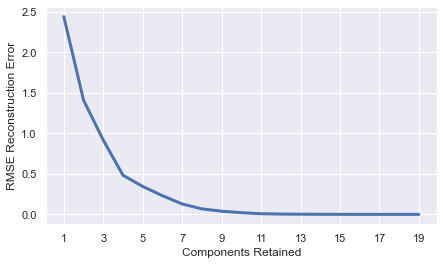

In [9]:
x, y = preprocessing(5, 16)     # using cell 5 for training
[train_x, train_y], [test_x, test_y] = prep_for_training(x, y)

# Import the module for PCA
from sklearn.decomposition import PCA

# Re-centre the data to have zero mean
X_for_pca = train_x - np.mean(train_x, axis=0)[np.newaxis, :]

# Compute std. deviation of L2 norm input vectors
l2_norm = np.sum(X_for_pca ** 2, axis=-1)
std_dev = np.std(l2_norm)

# Threshold for dimensionality reduction set to 1% of std. deviation
threshold = 0.01 * std_dev

rmse_vs_components = []   # List of RMSE vs n_components for plotting
desired_components = 19   # Start by assuming all components are necessary

# Iterate over number of retained dimensions
for n_components in range(1, 20):
    pca = PCA(n_components=n_components)

    # Fit PCA onto the input data
    pca.fit(X_for_pca)

    # Apply dimensionality reduction on X
    X_transformed = pca.transform(X_for_pca)

    # Transform back to the starting space to compute reconstruction error
    X_projected = pca.inverse_transform(X_transformed)

    # Compute RMSE reconstruction error
    rmse = np.sum((X_for_pca - X_projected) ** 2, axis=-1).mean()

    if rmse < threshold:
        desired_components = min(n_components, desired_components)

    rmse_vs_components.append(rmse)

# Plot RMSE vs Components Retained
plt.figure(figsize=(7, 4))
plt.xlabel('Components Retained', fontsize=12)
plt.ylabel('RMSE Reconstruction Error', fontsize=12)
plt.plot(np.arange(1, 20), rmse_vs_components, lw=3)
plt.xticks(np.arange(1, 20, 2))

print(red(f"{desired_components}", 'bold'), "components are sufficient to satisfy the RMSE reconstruction criterion")

In [10]:
n_components = desired_components # Sufficient dimensions after compression

# PCA with 8 retained dimensions
pca = PCA(n_components=n_components)
pca.fit(X_for_pca)

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# Print the shape for confirmation
print(train_x.shape)
print(test_x.shape) 

(134, 8)
(34, 8)


In [34]:
from simple_colors import *

# These functions train and evaluate their respective models. Models are saved as 
# global variables so they can be used in the later step of evaluating the model.
# Evaluataion is carried out on completely different cells which the model has not seen

def eval_svr(train, test, training = True):
    global svr

    if training:
        # Define a SVM regressor with a Gaussian kernel
        svr = SVR()

        # Train the model
        svr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(svr.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_mlp(train, test, training = True, layer_size = 100, max_iter = 100):
    global mlp
    
    if training: 
        # Define a regressor with 1 hidden layer
        mlp = MLPRegressor(hidden_layer_sizes = (layer_size,), max_iter = max_iter)
        # Train the model
        mlp.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(mlp.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_rf(train, test, training = True, n_estimators = 100):
    global regressor
    
    if training:
        # Define a random forest regressor
        regressor = RandomForestRegressor(n_estimators = n_estimators)
        # Train the model
        regressor.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(regressor.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_xgb(train, test, training = True):
    global xgbr
    
    if training:
        # Define a xgb regressor
        xgbr = XGBRegressor()
        # Train the model
        xgbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = xgbr.predict(test[0])
    print(blue(f"Evaluating the XGBoost Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_abr(train, test, training = True):
    global abr
    
    if training:
        # Define a adaboost regressor
        abr = AdaBoostRegressor()
        # Train the model
        abr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = abr.predict(test[0])
    print(blue(f"Evaluating the AdaBoost Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
    
def eval_lgbmr(train, test, training = True):
    global lgbmr

    if training:
        # Define a LightBGM regressor
        lgbmr = LGBMRegressor()
        # Train the model
        lgbmr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = lgbmr.predict(test[0])
    print(blue(f"Evaluating the LightBGM Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_cbr(train, test, training = True):
    global cbr
    
    if training:
        # Define a LightBGM regressor
        cbr = CatBoostRegressor()
        # Train the model
        cbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = cbr.predict(test[0])
    print(blue(f"Evaluating the CatBoost Regressor...", 'bold'))
    print(f"R2 Score = {metrics.r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [35]:
train, test = [train_x, train_y], [test_x, test_y]

eval_svr(train, test)
eval_rf(train, test)
eval_xgb(train, test)
eval_abr(train, test)
eval_lgbmr(train, test)
eval_cbr(train, test)

Evaluating the Support Vector Regressor...
R2 Score = 0.9012
RMSE = 0.0561
Evaluating the Random Forest Regressor...
R2 Score = 0.9965
RMSE = 0.0105
Evaluating the XGBoost Regressor...
R2 Score = 0.9906
RMSE = 0.0173
Evaluating the AdaBoost Regressor...
R2 Score = 0.9936
RMSE = 0.0143
Evaluating the LightBGM Regressor...
R2 Score = 0.9956
RMSE = 0.0118
Learning rate set to 0.029803
Evaluating the CatBoost Regressor...
R2 Score = 0.9921
RMSE = 0.0158


In [56]:
# Using an ARtificial Neural Network with LSTM and Dense layers
# Importing required libraries
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model3
from tqdm.keras import TqdmCallback

def create_model(plot = False, dpi = 96):
    inputs = Input(shape = (8,1), name = 'Input_features')
    lstm = LSTM(32, input_shape = (8,1))(inputs)
    dense2 = Dense(10)(lstm)
    output = Dense(1, name = 'Output_Layer')(dense2)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    if plot: 
        print("Visualizing the model and its layers :")
        display(plot_model(model, show_shapes = True, dpi = dpi))

    return model

def eval_nn(train, test, training = True, plot = True, dpi = 96):
    global nn
    
    if training: train_x = train[0].reshape(-1,8,1)
    test_x = test[0].reshape(-1,8,1)

    if training:
        # Define a LightBGM regressor
        nn = create_model(plot = True, dpi = dpi)
        # Train the model
        nn.fit(train_x, train[1], 
          epochs = 100, 
          batch_size = 1, 
          verbose = 0, 
          callbacks = [TqdmCallback(verbose = 0, ncols = 100)])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Artificial Neural Network...", 'bold'))
    rmse = nn.evaluate(test_x, test[1])

    print(f"RMSE = {rmse:.4f}")

Visualizing the model and its layers :


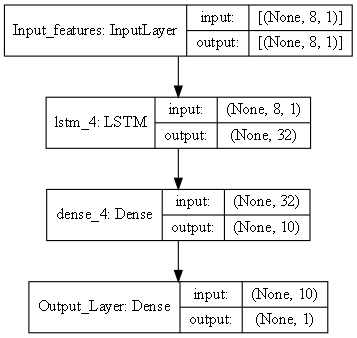

100%|████████████████████████████████████████████| 100/100 [00:28<00:00, 3.47epoch/s, loss=0.00017]


Evaluating the Artificial Neural Network...
2/2 [==============================] - 0s 2ms/step - loss: 2.9494e-04
RMSE = 0.0003


In [58]:
eval_nn(train, test, training = True, plot = True, dpi = 80)

In [72]:
# This function applies the previously trained models to the data of other cells
# which have not been used for the training process
def evaluate_cell(cell_number):
    print(red(f"Applying the previously trained models to data from cell {cell_number}"))
    
    x, y = preprocessing(cell_number, 16)
    x = scaler.transform(x)
    x = pca.transform(x)

    eval_lgbmr(_, [x, y], training = False)
    eval_rf(_, [x, y], training = False)
    eval_nn(_, [x, y], training = False, plot = False)
    
    plt.figure(figsize = (10,7))
    plt.plot(lgbmr.predict(x), label = "LightGBM Regressor")
    plt.plot(regressor.predict(x), label = "Random Forest Regressor")
    plt.plot(nn.predict(x.reshape(-1,8,1)), label = "Artificial Neural Network")
    plt.plot(y.reshape(-1,1), label = "True labels")
    plt.legend()
    plt.ylabel("Capacity of the battery (Ahr)", fontsize = 14)
    plt.show()

Applying the previously trained models to data from cell 7
Evaluating the LightBGM Regressor...
R2 Score = 0.9754
RMSE = 0.0252
Evaluating the Random Forest Regressor...
R2 Score = 0.9837
RMSE = 0.0205
Evaluating the Artificial Neural Network...
6/6 [==============================] - 0s 2ms/step - loss: 3.5272e-04
RMSE = 0.0004


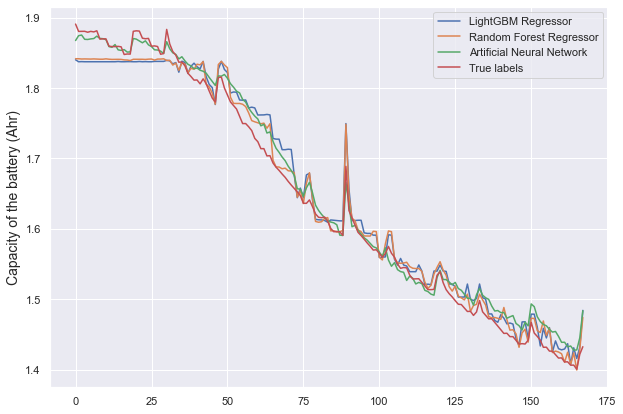

In [73]:
evaluate_cell(7)